In [1]:
from fastai.vision.all import *
from self_supervised.layers import *
from self_supervised.multimodal.clip import *
import clip
import gc

In [2]:
datapath = Path("plant-pathology-2021-fgvc8/")

In [3]:
datapath.ls()

(#5) [Path('plant-pathology-2021-fgvc8/train.csv'),Path('plant-pathology-2021-fgvc8/test_images'),Path('plant-pathology-2021-fgvc8/train_images_512'),Path('plant-pathology-2021-fgvc8/train_images'),Path('plant-pathology-2021-fgvc8/sample_submission.csv')]

In [4]:
train_df = pd.read_csv(datapath/'train.csv')

In [5]:
label_dist = train_df['labels'].value_counts()

In [6]:
label_dist

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
cider_apple_rust                   1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [7]:
train_df['num_disease'] = train_df['labels'].apply(lambda o: len(o.split()))

In [8]:
train_df.query("num_disease == 1")['labels'].value_counts()

scab                  4826
healthy               4624
frog_eye_leaf_spot    3181
cider_apple_rust      1860
complex               1602
powdery_mildew        1184
Name: labels, dtype: int64

In [9]:
train_df.query("num_disease > 1")['labels'].value_counts()

scab frog_eye_leaf_spot            686
scab frog_eye_leaf_spot complex    200
frog_eye_leaf_spot complex         165
rust frog_eye_leaf_spot            120
rust complex                        97
powdery_mildew complex              87
Name: labels, dtype: int64

In [10]:
# def read_img(im): return PILImage.create(datapath/f'train_images/{im}')

# img = read_img(train_df['image'][0])

# img.shape

# def resize_img(img, sz=512):
#     targ_sz = resize_to(img, use_min=True, targ_sz=sz)
#     return img.resize(targ_sz, resample=Image.BILINEAR).convert("RGB")

# resizepath = datapath/'train_images_512'

# resizepath.mkdir()

# fns = train_df['image'].values; fns[:5]

# def read_resize_save(fn):
#     img = read_img(fn)
#     img = resize_img(img)
#     img.save(resizepath/f'{fn}')

# # parallel(read_resize_save, fns, progress=True)

### Data

In [11]:
files = train_df['image'].values
fn2label = dict(zip(train_df['image'], train_df['labels'].apply(lambda o: o.split())))

In [12]:
def read_img(im): return PILImage.create(datapath/f'train_images_512/{im}')
def read_label(fn): return fn2label[fn]

In [13]:
def get_dls(files, bs=32, size=448, stats=imagenet_stats):

    tfms = [[read_img, ToTensor, RandomResizedCrop(size, min_scale=.7)], 
            [read_label, MultiCategorize(), OneHotEncode]]

    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1, seed=0.2)(files))

    batch_augs = aug_transforms()

    batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
    dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)
    return dls

In [14]:
import wandb
from fastai.callback.wandb import WandbCallback

In [15]:
# dls.show_batch()

In [16]:
# tf_efficientnet_b4_ns - lr 2e-2, size 448, bs 32
# resnet101d - lr 2e-2, size 448, bs 32
# vit_base_patch16_384 - lr 1e-3 size 384, bs 32 (checkpoint 2)
# vit_base_resnet50_384 - lr 1e-3 size 384 bs 24 (checkpoint 12)

In [17]:
# #export 
# from torch.utils.checkpoint import checkpoint_sequential
    
# class CheckpointVisionTransformer(Module):
#     def __init__(self, vit_model, checkpoint_nchunks=2):
#         self.checkpoint_nchunks = checkpoint_nchunks
#         self.vit_model = vit_model
    
#     def forward_features(self, x):
#         B = x.shape[0]
#         x = self.vit_model.patch_embed(x)

#         cls_tokens = self.vit_model.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
#         x = torch.cat((cls_tokens, x), dim=1)
#         x = x + self.vit_model.pos_embed
#         x = self.vit_model.pos_drop(x)
#         x = checkpoint_sequential(self.vit_model.blocks, self.checkpoint_nchunks, x)
#         x = self.vit_model.norm(x)[:, 0]
#         x = self.vit_model.pre_logits(x)
#         return x

#     def forward(self, x):
#         x = self.forward_features(x)
#         x = self.vit_model.head(x)
#         return x

In [18]:
from collections import OrderedDict
from typing import Tuple, Union


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.avgpool = nn.AvgPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            for conv, bn in [(self.conv1, self.bn1), (self.conv2, self.bn2), (self.conv3, self.bn3)]:
                x = self.relu(bn(conv(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None, checkpoint=False, checkpoint_nchunks=2):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])
        self.checkpoint = checkpoint
        self.checkpoint_nchunks = checkpoint_nchunks
        
    def forward(self, x: torch.Tensor):
        if self.checkpoint: return torch.utils.checkpoint.checkpoint_sequential(self.resblocks, self.checkpoint_nchunks, x)
        else:               return self.resblocks(x)


class VisualTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int, patch_stride=None, **kwargs):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        if patch_stride is None: patch_stride = patch_size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_stride, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        
        
        num_pathces = (input_resolution - patch_size + patch_stride) // patch_stride
        
        self.positional_embedding = nn.Parameter(scale * torch.randn(num_pathces ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads, **kwargs)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int,
                 **kwargs
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisualTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim,
                **kwargs
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask(),
            **kwargs
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.log(torch.tensor(1/0.07))) # Same initialization as paper

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)
        
        # visual model
        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)
        
        # text model
        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        return image_features, text_features

In [19]:
def create_vitb_model(size, patch_size=32, patch_stride=32, clip_pretrained=True, checkpoint=False, checkpoint_nchunks=2):
    "ViT-B model with 12 layers, 12 heads, width 768, embed size 512 and custom patch size and stride size"
    if clip_pretrained:
        if patch_size != 32 and patch_stride != 32: raise Exception(f"Patch size and stride needs to be 32 for pretrained model")
        print("Loading pretrained model..")
        vitb32_config_dict = vitb32_config(224, context_length=77, vocab_size=49408)
        clip_model = CLIP(**vitb32_config_dict, checkpoint_nchunks=checkpoint_nchunks)
        clip_pretrained_model, _ = clip.load("ViT-B/32", jit=False)
        clip_model.load_state_dict(clip_pretrained_model.state_dict())

        clip_vitb = clip_model.visual
        num_patches = (size//patch_size)**2 +1
        # interpolate positional embedding to match any input size
        embed_dim = clip_vitb.positional_embedding.size(1)
        clip_vitb.positional_embedding.data = F.interpolate(clip_vitb.positional_embedding.data[None, None, ...], 
                                                            size=[num_patches, embed_dim], 
                                                            mode='bilinear',align_corners=False)[0,0]
        del clip_model, clip_pretrained_model
        gc.collect()
        torch.cuda.empty_cache()
    else:
        clip_vitb = VisualTransformer(size,patch_size=patch_size,patch_stride=patch_stride,
                                      width=768,layers=12,heads=12,output_dim=512,
                                      checkpoint=checkpoint, checkpoint_nchunks=checkpoint_nchunks)
    
    return clip_vitb

In [20]:
class VisualTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_sizes: list, width: int, layers: int, heads: int, output_dim: int, patch_strides=None, **kwargs):
        "A Vision Transformer with sliding patch and multi scale patch support"
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        
        if isinstance(patch_sizes, int):   patch_sizes   = listify(patch_sizes)
        if isinstance(patch_strides, int): patch_strides = listify(patch_strides) 
        if patch_strides is None: patch_strides = patch_sizes
        
        self.convs = nn.ModuleList([])
        num_patches = 0
        for patch_sz, stride_sz in zip(patch_sizes, patch_strides):
            self.convs += [nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_sz, stride=stride_sz, bias=False)]
            num_patches += ((input_resolution - patch_sz + stride_sz) // stride_sz)**2
            
        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        
                
        self.positional_embedding = nn.Parameter(scale * torch.randn(num_patches + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads, **kwargs)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, inp: torch.Tensor):
        patch_embeds = []
        for conv in self.convs:
            out = conv(inp)  # shape = [*, width, grid, grid]
            out = out.reshape(out.shape[0], out.shape[1], -1)  # shape = [*, width, grid ** 2]
            patch_embeds.append(out)
        
        x = torch.cat(patch_embeds, dim=-1)
        
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x

In [21]:
### to much memory: 16 / 8 : bs 16 size 384 lr 1e-4 gradcheck 0
# 16 / 16 : bs 16 size 384 lr 1e-4 gradcheck 0 (24 x 24)
# 32 / 16 : bs 16 size 384 lr 1e-4 gradcheck 2 (23 x 23)
# 32 / 32 : bs 32 size 384 lr 1e-4 gradcheck 0 (12 x 12)
# 64 / 32 : bs 32 size 384 lr 1e-4 gradcheck 0 (11 x 11)
# 64 / 64 : bs 32 size 384 lr 1e-4 gradcheck 0 (6 x 6)

In [22]:
bs, size, lr, epochs = 16, 384, 2e-2, 24
patch_sizes, patch_strides = [32, 16], None
clip_pretrained=False
checkpoint=True
checkpoint_nchunks=2
dls = get_dls(files,bs,size)

In [23]:
WANDB = False

In [24]:
if WANDB:
    xtra_config = {"Arch":arch, "Size":size, "lr": lr}
    wandb.init(project="plant-pathology-2021", config=xtra_config)

In [25]:
@patch
def name(self:F1ScoreMulti): return "f1_multi_macro"
f1macro = F1ScoreMulti(average='macro')
@patch
def name(self:F1ScoreMulti): return "f1_multi_micro"
f1micro = F1ScoreMulti(average='micro')

In [26]:
encoder = VisualTransformer(size,patch_sizes=patch_sizes, patch_strides=patch_strides,
                                      width=768,layers=12,heads=12,output_dim=512,
                                      checkpoint=checkpoint, checkpoint_nchunks=checkpoint_nchunks)
with torch.no_grad(): nf = encoder(torch.randn(2,3,size,size)).size(-1)
classifier = create_cls_module(nf, dls.c)
model = nn.Sequential(encoder, classifier)
cbs = [SaveModelCallback(every_epoch=True, fname=f"vitb-{patch_sizes}/{patch_strides}_size{size}_lr{lr}_epochs{epochs}")]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
learn = Learner(dls, model, opt_func=ranger, cbs=cbs,
                metrics=[f1macro, f1micro], loss_func=BCEWithLogitsLossFlat())
learn.to_fp16();

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.43651583790779114)

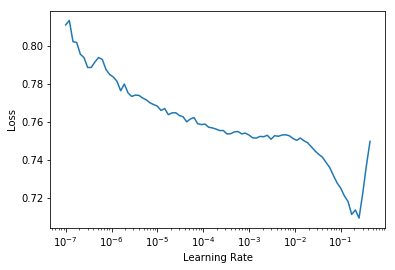

In [27]:
learn.lr_find()

In [28]:
if WANDB: wandb.finish()